In [1]:
from IPython import display
from IPython.display import Markdown as md


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Read data

In [2]:
from functools import reduce
df = pd.read_csv("songs998.csv", index_col=0).dropna(subset=["Lyrics"])
df["sentence"] = df["Lyrics"].str.split(".")
df

,Artist,Song,Lyrics,sentence
0,The Weeknd,The Hills,[Intro].Yeah.Yeah.Yeah..[Verse 1].Your man on ...,"[[Intro], Yeah, Yeah, Yeah, , [Verse 1], Your ..."
1,The Weeknd,Starboy,"[Verse 1].I'm tryna put you in the worst mood,...","[[Verse 1], I'm tryna put you in the worst moo..."
2,The Weeknd,Can’t Feel My Face,[Produced by Max Martin]..[Verse 1].And I know...,"[[Produced by Max Martin], , [Verse 1], And I ..."
3,The Weeknd,Reminder,[Verse 1].Record man play my song on the radio...,"[[Verse 1], Record man play my song on the rad..."
4,The Weeknd,Call Out My Name,[Verse 1].We found each other.I helped you out...,"[[Verse 1], We found each other, I helped you ..."
...,...,...,...,...
993,Justin Bieber,Love Yourself - Acoustic (with Ed Sheeran) [Bo...,[Verse 1].All the times that you rained on my ...,"[[Verse 1], All the times that you rained on m..."
994,Justin Bieber,I’ll Show you (Acoustic) - Live,[Verse 1].My life is a movie and everyone's wa...,"[[Verse 1], My life is a movie and everyone's ..."
995,Justin Bieber,Love Yourself (Acoustic) - Live,[Verse 1].For all the times that you rained on...,"[[Verse 1], For all the times that you rained ..."
996,Justin Bieber,Trust (Acoustic) - Live,[Chorus].If I believe in love.And you believe ...,"[[Chorus], If I believe in love, And you belie..."


In [3]:
sentence = []
for sublist in df["sentence"]:
    sentence.extend(sublist)

sentence = pd.Series([ x.strip() for x in sentence if (x.strip() != "") and (not x.strip().startswith("[")) and (len(x.split()) >3)])
sentence = sentence.str.replace("'", "")
sentence = sentence.apply(lambda x: (" ".join([t for t in x.split() if not t.isnumeric()])))
sentence

0                      Your man on the road, he doin promo
1             You said, "Keep our business on the low-low"
2                Im just tryna get you out the friend zone
3               Cause you look even better than the photos
4                 I cant find your house, send me the info
                               ...                        
40819                            Scene goes frame by frame
40820                                  Who swayed to suede
40821                          Youll hear it all dont call
40822             Throw away everything Ive written you oh
40823    Anything just like every single thing todayEmb...
Length: 40824, dtype: object

# Vectorise

In [44]:
vectorizer = CountVectorizer(decode_error='ignore')
total_features_words = vectorizer.fit_transform(sentence)
total_features_words.shape
# 7042 -> Training instances
# 21954 -> Total words


(40824, 8556)

Need to trim the vocab size. Filter by IDF value?

In [45]:
vectorizer = TfidfVectorizer(decode_error='ignore'
                            # ,ngram_range = (1,2)
                            ,use_idf = True
                            ,strip_accents = 'ascii'
                            ,smooth_idf = False
                            )
song_vectors = vectorizer.fit_transform(sentence)
print(song_vectors.shape)
# 7042 -> Training instances
# 21954 -> Total words
print(min(vectorizer.idf_), max(vectorizer.idf_))
idf_vocab = pd.Series(vectorizer.idf_, index= vectorizer.get_feature_names())
idf_vocab.sort_values()


(40824, 8489)
2.1573280926375116 11.617025422743808


/Users/rchaks/opt/anaconda3/envs/aml-proj/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


you            2.157328
the            2.761505
me             2.898852
to             2.982938
and            3.214794
                ...    
cullens       11.617025
cuh           11.617025
pained        11.617025
cuello        11.617025
zzzzingggg    11.617025
Length: 8489, dtype: float64

Text(0.5, 1.0, 'Word Distribution')

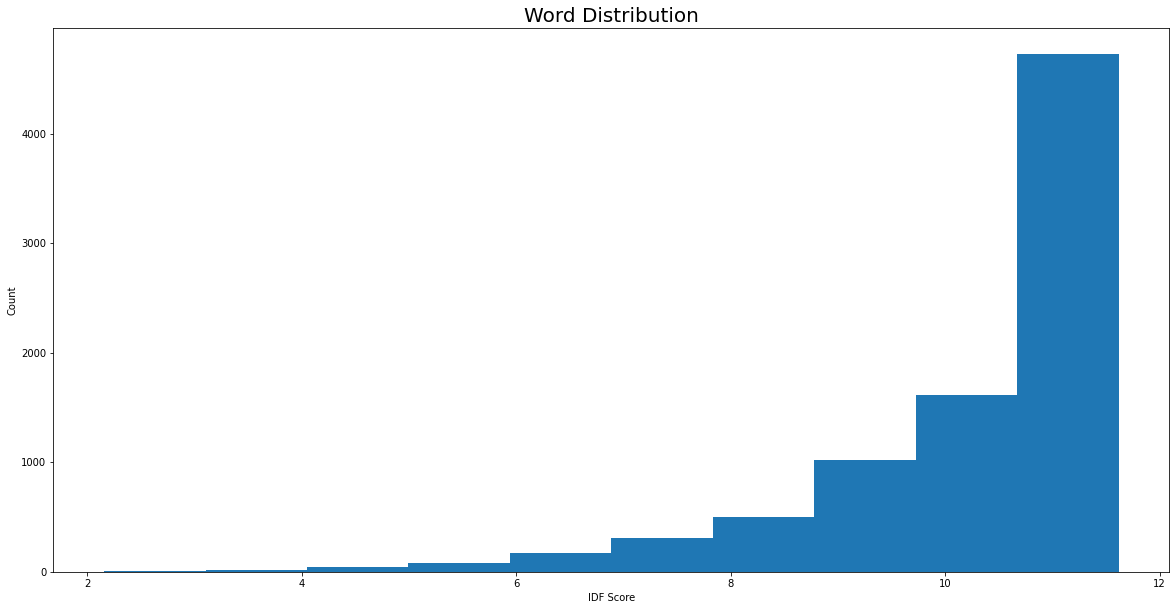

In [46]:
plt.figure(figsize = (20,10))
plt.hist(vectorizer._tfidf.idf_)
plt.xlabel("IDF Score")
plt.ylabel("Count")
plt.title("Word Distribution", fontsize = 20)
        

In [47]:
# Selecting top 10% most frequently occouring words
vocab = idf_vocab[idf_vocab <= idf_vocab.quantile(q = 0.15)]
print(idf_vocab.quantile(q = 0.2), len(vocab))

vocab = pd.Series([t for t in vocab.index if not t.isnumeric()], dtype=str)
vocab

9.37765663914447 1279


0           abel
1          about
2          above
3         across
4            act
          ...   
1271    yourself
1272       youve
1273         yum
1274       yummy
1275        zone
Length: 1276, dtype: object

In [48]:

vectorizer = CountVectorizer(decode_error='ignore'
                            # ,ngram_range = (1,2)
                            ,strip_accents = 'ascii'
                            # ,smooth_idf = False
                            ,vocabulary = set(vocab)
                        )
X = vectorizer.fit_transform(sentence)
print(X.shape)
# 7042 -> Training instances
# 21954 -> Total words
vocab= vectorizer.get_feature_names_out()
print(vocab.shape, vocab)
print(X.toarray()[1])

(40824, 1276)
(1276,) ['abel' 'about' 'above' ... 'yum' 'yummy' 'zone']
[0 0 0 ... 0 0 0]


https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-rnn-cb6ebc594677

# RNN

In [28]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [52]:
# Number of features used as input. (Number of columns)
INPUT_SIZE = 1
# Number of previous time stamps taken into account.
SEQ_LENGTH = 5
# Number of features in last hidden state ie. number of output time-
# steps to predict.See image below for more clarity.
HIDDEN_SIZE = 2
# Number of stacked rnn layers.
NUM_LAYERS = 5
# We have total of 20 rows in our input. 
# We divide the input into 4 batches where each batch has only 1
# row. Each row corresponds to a sequence of length 5. 
BATCH_SIZE = 4

num_batches = X.shape[0]//BATCH_SIZE

dataloader = DataLoader(X, batch_size= BATCH_SIZE)

noise_input_dimension = 516

dataloader

In [43]:
# Initialize the RNN.
rnn = nn.RNN(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers = 1, batch_first=True)
# input size : (batch, seq_len, input_size)
inputs = X[0].view(BATCH_SIZE, SEQ_LENGTH, INPUT_SIZE)
# out shape = (batch, seq_len, num_directions * hidden_size)
# h_n shape  = (num_layers * num_directions, batch, hidden_size)
out, h_n = rnn(inputs)

RuntimeError: shape '[4, 5, 1]' is invalid for input of size 1276